## This notebook will help you train a latent Point-Cloud GAN.

(Assumes
latent_3d_points is in the PYTHONPATH and that a trained AE model exists)

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import os
import os.path as osp
import sys
import matplotlib.pylab as plt

BASE = os.path.dirname(os.path.abspath(os.path.dirname("file"))) # latent_3D
sys.path.append(BASE) 

from src.point_net_ae import PointNetAutoEncoder
from src.autoencoder import Configuration as Conf
from src.neural_net import MODEL_SAVER_ID

from src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from src.general_utils import plot_3d_point_cloud
from src.tf_utils import reset_tf_graph

from src.vanilla_gan import Vanilla_GAN
from src.w_gan_gp import W_GAN_GP
from src.generators_discriminators import latent_code_discriminator_two_layers,\
latent_code_generator_two_layers

Instructions for updating:
Colocations handled automatically by placer.
Success


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Specify where the raw point-clouds and the pre-trained AE are.

In [3]:
# Top-dir of where point-clouds are stored.
class_name = 'chair'
ae_loss = 'chamfer'  
top_in_dir = 'data/shape_net_core_uniform_samples_2048/'    

# ae_configuration = '../data/single_class_ae/configuration'
ae_configuration = 'single_class_ae_' + ae_loss
ae_configuration = osp.join(BASE, 'data', class_name, ae_configuration, 'configuration')
# ae_configuration = osp.join(BASE, 'data', class_name, 'single_class_ae/configuration')

In [4]:
# Where to save GANs check-points etc.
top_out_dir = 'data/'

top_out_dir = osp.join(BASE, top_out_dir, class_name)
top_in_dir = osp.join(BASE, top_in_dir)

experiment_name = 'latent_gan_with_chamfer_ae'
# experiment_name = osp.join(BASE, 'data', class_name, 'latent_gan_with_chamfer_ae')

ae_epoch = 1500           # Epoch of AE to load.
bneck_size = 128         # Bottleneck-size of the AE
n_pc_points = 2048       # Number of points per model.

# class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()

In [5]:
# Load point-clouds.
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)
print ('Shape of DATA =', all_pc_data.point_clouds.shape)

6778 pclouds were loaded. They belong in 1 shape-classes.
Shape of DATA = (6778, 2048, 3)


In [6]:
# Load pre-trained AE
reset_tf_graph()
ae_conf = Conf.load(ae_configuration)
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
ae.restore_model(ae_conf.train_dir, ae_epoch, verbose=True)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/single_class_ae_chamfer/models.ckpt-1500
Model restored in epoch 1500.


In [7]:
# Use AE to convert raw pointclouds to latent codes.
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)
latent_data = PointCloudDataSet(latent_codes)
print ('Shape of DATA =', latent_data.point_clouds.shape)

Shape of DATA = (6778, 128)


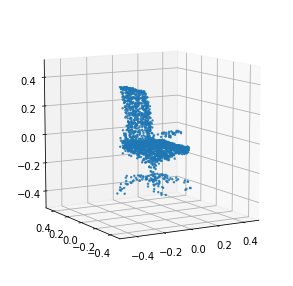

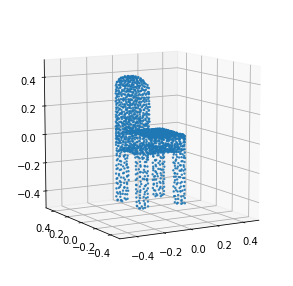

In [8]:
# Check the decoded AE latent-codes look descent.
L = ae.decode(latent_codes)
i = 0
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);
i = 20
plot_3d_point_cloud(L[i][:, 0], L[i][:, 1], L[i][:, 2], in_u_sphere=True);

In [9]:
# Set GAN parameters.

use_wgan = True     # Wasserstein with gradient penalty, or not?
n_epochs = 200        # Epochs to train.

plot_train_curve = True
# save_gan_model = False
save_gan_model = True
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])

# If true, every 'saver_step' epochs we produce & save synthetic pointclouds.
save_synthetic_samples = True
# How many synthetic samples to produce at each save step.
n_syn_samples = latent_data.num_examples

# Optimization parameters
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = bneck_size
beta = 0.5 # ADAM's momentum.

n_out = [bneck_size] # Dimensionality of generated samples.

if save_synthetic_samples:
    synthetic_data_out_dir = osp.join(top_out_dir, 'OUT/synthetic_samples/', experiment_name)
    create_dir(synthetic_data_out_dir)

if save_gan_model:
    train_dir = osp.join(top_out_dir, 'OUT/latent_gan', experiment_name)
    create_dir(train_dir)

In [10]:
reset_tf_graph()

if use_wgan:
    lam = 20 # lambda of W-GAN-GP
    gan = W_GAN_GP(experiment_name, init_lr, lam, n_out, noise_dim, \
                  latent_code_discriminator_two_layers, 
                  latent_code_generator_two_layers,\
                  beta=beta)
else:    
    gan = Vanilla_GAN(experiment_name, init_lr, n_out, noise_dim,
                     latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                     beta=beta)

In [11]:
accum_syn_data = []
train_stats = []

1 (0.4779572096135881, 0.012751781899068091)
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/OUT/latent_gan/latent_gan_with_chamfer_ae/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


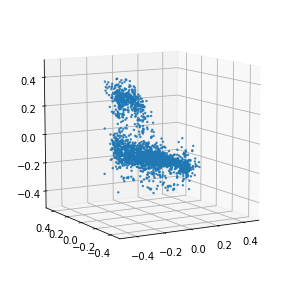

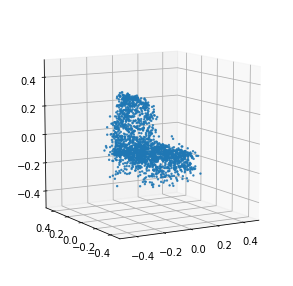

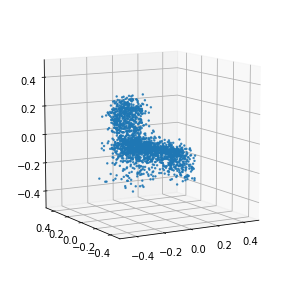

2 (-0.5754895159491786, 0.1387186627145167)
3 (-0.5861772802140978, 0.004856628314074542)
4 (-0.5068741579850514, -0.06952650058600637)
5 (-0.4536005538922769, -0.04220971968714838)
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/OUT/latent_gan/latent_gan_with_chamfer_ae/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.


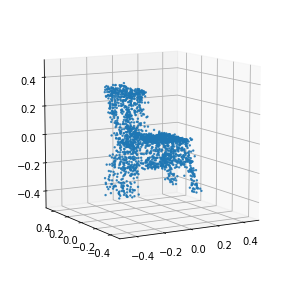

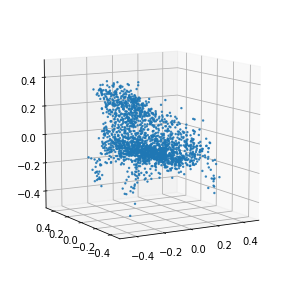

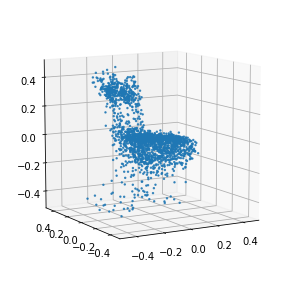

6 (-0.4348720954524146, 0.02651800222574147)
7 (-0.43764998581674364, 0.08788099277902532)
8 (-0.4487203635551311, 0.09171479443709056)
9 (-0.45409701841848865, 0.06035742239543685)
10 (-0.45811082235089057, 0.02179307934474545)
INFO:tensorflow:/home/sohee/coding/PointCloud/lgan/latent_3d_points/data/chair/OUT/latent_gan/latent_gan_with_chamfer_ae/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


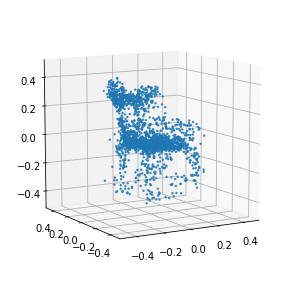

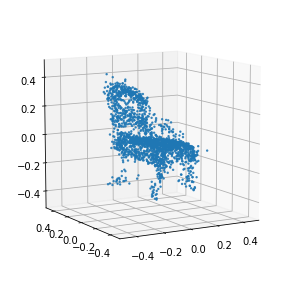

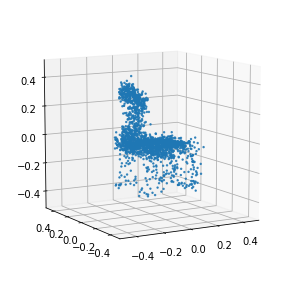

11 (-0.4590992068802869, -0.005351730855181813)
12 (-0.45725445173404833, -0.009305539336141751)
13 (-0.45734176105923124, -0.02004118462705433)
14 (-0.4545217134334423, -0.03551397058698866)
15 (-0.4503573347021032, -0.038535101339221)
16 (-0.44723454382684497, -0.04840557801502722)
17 (-0.4441725933993304, -0.05653802581407406)
18 (-0.43683698287716616, -0.06874501498209105)
19 (-0.4317186589594241, -0.05505852304674961)
20 (-0.42479643821716306, -0.07631418757416585)
21 (-0.4180637178597627, -0.08148504904022923)
22 (-0.410044554427818, -0.07724017125588876)
23 (-0.4018889957004123, -0.07510491308790666)
24 (-0.3936596965348279, -0.084885373711586)
25 (-0.38536127474572923, -0.08421998981524396)
26 (-0.3773061864905887, -0.09385514866422724)
27 (-0.36757981423978453, -0.09393434806002511)
28 (-0.3592663692103492, -0.08462777899371253)
29 (-0.35065631557393956, -0.0969345086702594)
30 (-0.34361665977372063, -0.09793755853617633)
31 (-0.33651973075336883, -0.09611306229123363)
32 (-0.

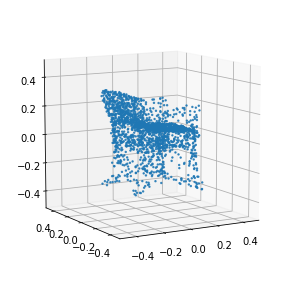

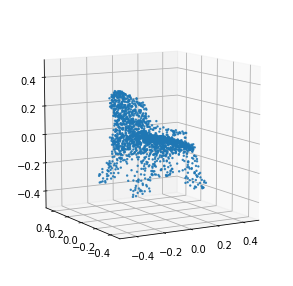

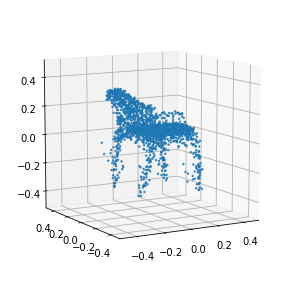

51 (-0.20717144321512293, -0.1710447304778629)
52 (-0.20115904973612891, -0.16579256841429957)
53 (-0.19858637275519195, -0.17683540174254664)
54 (-0.19284135346059447, -0.18578935442147432)
55 (-0.18856122217796467, -0.19380331922460486)
56 (-0.18362962747061695, -0.19949979583422342)
57 (-0.1794124241228457, -0.18650429723439393)
58 (-0.17594614779507672, -0.20175229840808445)


In [ ]:
# Train the GAN.
for _ in range(n_epochs):
    loss, duration = gan._single_epoch_train(latent_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.increment_epoch))
    print (epoch, loss)

    if save_gan_model and epoch in saver_step:
        checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
        gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)

    if save_synthetic_samples and epoch in saver_step:
        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
        for k in range(3):  # plot three (syntetic) random examples.
            plot_3d_point_cloud(syn_data[k][:, 0], syn_data[k][:, 1], syn_data[k][:, 2],
                               in_u_sphere=True)

    train_stats.append((epoch, ) + loss)

In [ ]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s)' %(class_name))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [ ]:

f = open(osp.join(synthetic_data_out_dir, 'gan_loss.txt'), 'a')

for k in range(0,len(train_stats)):
    f.write('%4d\t%10f\t%10f\n' %(train_stats[k][0],train_stats[k][1],train_stats[k][2]))
    
f.close()


In [ ]:
# k=len(syn_data)-1

# print(k-1)

# plot_3d_point_cloud(syn_data[k][:, 0], 
#                     syn_data[k][:, 1], 
#                     syn_data[k][:, 2], in_u_sphere=True)


In [ ]:

# import tensorflow as tf
# import errno

# def make_sure_path_exists(path):
#     try:
#         os.makedirs(path)
#     except OSError as exception:
#         if exception.errno != errno.EEXIST:
#             raise
            
# txt_path = (osp.join(synthetic_data_out_dir, 'l-gan'))
     
# make_sure_path_exists(txt_path)    

# l = len(syn_data)


# for i in range(0,l):
#     xx = syn_data[i][:, 0]
#     x = xx.tolist()
#     yy = syn_data[i][:, 1]
#     y = yy.tolist()
#     zz = syn_data[i][:, 2]
#     z = zz.tolist()
    
#     p = open(osp.join(txt_path, 'l-GAN_'+str(i).zfill(5)+'.txt'), 'w+')
#     for k in range(0,2048):
#         p.write('%8f\t%8f\t%8f\n' %(x[k], y[k], z[k]))
#     p.close()
        
# print("Created GAN reconstruction.txt")

In [ ]:
# import numpy as np
# # np.save("/home/sohee/coding/latent_3d_points/result/chair/single_class_ae/ae_re.npy", reconstructions)
# np.save(osp.join(conf.train_dir, "l-GAN.npy"), reconstructions)
